In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
ls /content/drive/MyDrive/HW5

 HW5.ipynb     predictions_model/    'Untitled presentation.gslides'
 model_save/   sample_data_HW5.xlsx


In [ ]:
cd /content/drive/MyDrive/HW5

/content/drive/MyDrive/HW5


In [ ]:
from pathlib import Path
path = Path("./predictions_model")
path_model = Path("./model_save")
Path(path).mkdir(exist_ok=True)
Path(path_model).mkdir(exist_ok=True)

# Task 1

In [ ]:
import pandas as pd
import sklearn.preprocessing as sp

sample_data = pd.read_excel('sample_data_HW5.xlsx')
mms = sp.MinMaxScaler(feature_range=(0, 1))
sample_data["SPOT_"] = mms.fit_transform(sample_data.loc[:, ["close_spot"]])
sample_data["FUT_"] = mms.fit_transform(sample_data.loc[:, ["close_1m"]])
train_data = sample_data.loc[sample_data["ts_event_1m"] < "2023", :]
test_data = sample_data.loc[sample_data["ts_event_1m"] >= "2023", :]

In [ ]:
train_data.shape

(3179, 6)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
import sklearn.pipeline as pl
import sklearn.preprocessing as sp
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
from typing import List, Tuple, Callable


In [ ]:
def build_deep_learning_model(name):
    def MNN(input_shape):
      model = models.Sequential()
      model.add(layers.Input(shape=input_shape))
      model.add(layers.Dense(32, activation="relu"))
      model.add(layers.Dense(32, activation="relu"))
      model.add(layers.Dense(1))
      custom_adam = optimizers.Adam(
          learning_rate = 0.01,
          beta_1 = 0.08,
          beta_2 = 0.07,
          epsilon = 10e-7
      )
      model.compile(optimizer=custom_adam, loss="mse")
      return model

    def RNN(input_shape):
      model = models.Sequential()
      model.add(layers.Input(shape=input_shape))
      model.add(layers.SimpleRNN(50, return_sequences=True))
      model.add(layers.LeakyReLU(negative_slope=0.05))
      model.add(layers.SimpleRNN(50))
      model.add(layers.LeakyReLU(negative_slope=0.05))
      model.add(layers.Dense(1))
      custom_adam = optimizers.Adam(
          learning_rate = 0.01,
          beta_1 = 0.08,
          beta_2 = 0.07,
          epsilon = 10e-7
      )
      model.compile(optimizer=custom_adam, loss="mse")
      return model

    if name == "MNN":
      return MNN
    elif name == "RNN":
      return RNN

def convert_data(X, Y, timesteps = 14, step = 1):
  result_x, result_y = [], []
  for start in range(0, X.shape[0]-timesteps, step):
    end = start + timesteps
    result_x.append(X.iloc[start:end])
    result_y.append(Y.iloc[end])
  return np.array(result_x), np.array(result_y)

def k_folds_models_metrics(data: pd.DataFrame, models_list: list[Tuple[str, Callable]], metrics: list, n_splits=5, shuffle=True, random_state=89) -> None:
  """
  data: train data
  models: list of models
  metrics: list of metrics
  n_splits: number of splits
  shuffle: shuffle data
  random_state: random state
  """
  kf = KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
  print(f"{n_splits} folds:")
  for model in models_list:
    print(model[0])
    r2_train = []
    r2_test = []

    for i, (train_index, test_index) in enumerate(kf.split(train_data)):
      x_train, x_test = data.loc[train_index, ["FUT_"]], data.loc[test_index, ["FUT_"]]
      y_train, y_test = data.loc[train_index, "SPOT_"], data.loc[test_index, "SPOT_"]

      if model[0] == "MNN":
        # to make MNN compatible with this method
        model_ = model[1](input_shape=(x_train.shape[1],))
        model_.fit(x_train, y_train, epochs=10, batch_size=32, verbose=0)
        y_pred_train = model_.predict(x_train)
        y_pred_test = model_.predict(x_test)

      elif model[0] == "RNN":
        # to make RNN compatible with this method
        x_train, y_train = convert_data(x_train, y_train, timesteps=10)
        x_test, y_test = convert_data(x_test, y_test)
        model_ = model[1](input_shape=x_train.shape[1:])
        model_.fit(x_train, y_train, epochs=10, batch_size=32, verbose=0)
        y_pred_train = model_.predict(x_train).flatten()
        y_pred_test = model_.predict(x_test).flatten()

      else:
        # other models
        model_ = model[1]
        model_.fit(x_train, y_train)
        y_pred_train = model_.predict(x_train)
        y_pred_test = model_.predict(x_test)

      train_measure = {metric.__name__: metric(y_train, y_pred_train) for metric in metrics}
      train_metrics = ", ".join([f"{name}: {value:.5f}" for name, value in train_measure.items()])
      test_measure = {metric.__name__: metric(y_test, y_pred_test) for metric in metrics}
      test_metrics = ", ".join([f"{name}: {value:.5f}" for name, value in test_measure.items()])
      i += 1
      r2_train.append(train_measure.get("r2_score"))
      r2_test.append(test_measure.get("r2_score"))
      print(f"{i} - train - {train_metrics}")
      print(f"{i} - test - {test_metrics}")
    print(f"Average of R2 of training data: {sum(r2_train) / len(r2_train):.5f}")
    print(f"Average of R2 of testing data: {sum(r2_test) / len(r2_test):.5f}")
    print()
  pass


In [ ]:
linear = ["linear", LinearRegression(fit_intercept=True)]
lasso = ["lasso", Lasso(fit_intercept=True, max_iter=1000, alpha=0.03)]
ridge = ["ridge", Ridge(fit_intercept=True, max_iter=1000, alpha=0.03)]
elastic_net = ["ElasticNet", ElasticNet(alpha=0.03, l1_ratio=0.5, fit_intercept=True, max_iter=1000)]
poly = ("polynomial", pl.make_pipeline(sp.PolynomialFeatures(3, include_bias=True), LinearRegression(fit_intercept=True)))
gradient_boosting = ("gradient_boosting", GBR(criterion="squared_error", n_estimators=80, learning_rate=0.04, max_depth=5, min_samples_split=20, random_state=89))
random_forest = ("random_forest", RFR(bootstrap=True, n_estimators=80, max_depth=5, min_samples_split=25, criterion="squared_error", random_state=89))
mnn = ("MNN", build_deep_learning_model("MNN"))
rnn = ("RNN", build_deep_learning_model("RNN"))
#linear, poly, gradient_boosting, random_forest, mnn, rnn

In [ ]:
models_ = [linear, lasso, ridge, elastic_net, poly, gradient_boosting, random_forest, mnn, rnn]
metrics = [mean_squared_error, root_mean_squared_error, r2_score]
k_folds_models_metrics(train_data, models_, metrics)

5 folds:
linear
1 - train - mean_squared_error: 0.01101, root_mean_squared_error: 0.10491, r2_score: 0.24215
1 - test - mean_squared_error: 0.01273, root_mean_squared_error: 0.11284, r2_score: 0.22162
2 - train - mean_squared_error: 0.01111, root_mean_squared_error: 0.10542, r2_score: 0.22885
2 - test - mean_squared_error: 0.01233, root_mean_squared_error: 0.11105, r2_score: 0.26642
3 - train - mean_squared_error: 0.01164, root_mean_squared_error: 0.10791, r2_score: 0.24317
3 - test - mean_squared_error: 0.01019, root_mean_squared_error: 0.10097, r2_score: 0.20959
4 - train - mean_squared_error: 0.01136, root_mean_squared_error: 0.10659, r2_score: 0.22763
4 - test - mean_squared_error: 0.01132, root_mean_squared_error: 0.10640, r2_score: 0.27500
5 - train - mean_squared_error: 0.01162, root_mean_squared_error: 0.10781, r2_score: 0.24637
5 - test - mean_squared_error: 0.01028, root_mean_squared_error: 0.10139, r2_score: 0.19387
Average of R2 of training data: 0.23763
Average of R2 of te

Ridge: [MSE: 0.00659, RMSE: 0.08115, r2: -0.03021]


In [ ]:
models_ = [linear, poly, gradient_boosting, random_forest, mnn, rnn]
for name, model in models_[:-2]:
  model.fit(train_data.loc[:, ["FUT_"]], train_data.SPOT_)
  predict_test_y = model.predict(test_data.loc[:, ["FUT_"]])
  MSE = mean_squared_error(test_data.SPOT_, predict_test_y)
  RMSE = root_mean_squared_error(test_data.SPOT_, predict_test_y)
  r2 = r2_score(test_data.SPOT_, predict_test_y)
  if name == "polynomial" and False: # False on purpose to see the coef_
    print(model.named_steps.get("linearregression").coef_)
  print(f"{name}: [MSE: {MSE:.5f}, RMSE: {RMSE:.5f}, r2: {r2:.5f}]")

linear: [MSE: 0.00659, RMSE: 0.08115, r2: -0.03026]
polynomial: [MSE: 0.00638, RMSE: 0.07985, r2: 0.00264]
gradient_boosting: [MSE: 0.01675, RMSE: 0.12942, r2: -1.62040]
random_forest: [MSE: 0.01439, RMSE: 0.11995, r2: -1.25074]


In [ ]:
X = train_data.loc[:, ["FUT_"]]
model = mnn[1](X.shape)
model.fit(train_data.loc[:, ["FUT_"]], train_data.SPOT_, epochs=10, batch_size=32, verbose=0)
pre_y = model.predict(test_data.loc[:, ["FUT_"]]).squeeze()
MSE = mean_squared_error(test_data.SPOT_, pre_y)
RMSE = root_mean_squared_error(test_data.SPOT_, pre_y)
r2 = r2_score(test_data.SPOT_, pre_y)
print(mnn[0]+":", MSE, RMSE, r2)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MNN: 0.006429664446878857 0.08018518845072858 -0.005862822196395223


In [ ]:
X, Y = convert_data(train_data.loc[:, ["FUT_"]], train_data.loc[:, "SPOT_"])
test_x, test_y = convert_data(test_data.loc[:, ["FUT_"]], test_data.loc[:, "SPOT_"])
model = rnn[1]((14, 1))
model.fit(X, Y, epochs=10, batch_size=32, verbose=0)
predict_test_y = model.predict(test_x)
MSE = mean_squared_error(test_y, predict_test_y)
RMSE = root_mean_squared_error(test_y, predict_test_y)
r2 = r2_score(test_y, predict_test_y)
print(rnn[0]+":", MSE, RMSE, r2)


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
RNN: 0.010663779622752084 0.10326557811174102 -0.6720636466619192


Comparing the average $R^2$ results from Gradient Boosting Regression (GBR) and Random Forest Regression (RFR), I observe that GBR exhibits signs of overfitting. This is indicated by a higher $R^2$ on in-sample data but a lower $R^2$ on out-of-sample data. Therefore, **RFR is rather preferred**.

In [ ]:
test_data


,ts_event_spot,close_spot,ts_event_1m,close_1m,SPOT_,FUT_
3179,2023-02-09 15:56:00,77.65,2023-01-09 15:56:00,76.00,0.393572,0.393830
3180,2023-03-09 08:15:00,77.34,2023-02-09 08:15:00,78.69,0.387879,0.431042
3181,2023-03-09 08:42:00,77.53,2023-02-09 08:42:00,78.72,0.391368,0.431457
3182,2023-03-09 11:32:00,76.82,2023-02-09 11:32:00,78.71,0.378329,0.431318
3183,2023-03-09 11:36:00,76.67,2023-02-09 11:36:00,78.59,0.375574,0.429658
...,...,...,...,...,...,...
4595,2024-02-08 18:03:00,76.39,2024-01-08 18:03:00,70.39,0.370432,0.316226
4596,2024-02-08 18:17:00,76.43,2024-01-08 18:17:00,70.39,0.371166,0.316226
4597,2024-02-08 18:22:00,76.43,2024-01-08 18:22:00,70.34,0.371166,0.315535
4598,2024-02-08 19:28:00,76.35,2024-01-08 19:28:00,70.71,0.369697,0.320653


## Task 2 With Moving Window

In [ ]:
sample_data.head()

,ts_event_spot,close_spot,ts_event_1m,close_1m,SPOT_,FUT_
0,2021-02-04 13:29:00,56.22,2021-01-04 13:29:00,48.37,0.000000,0.011620
1,2021-02-04 14:29:00,56.25,2021-01-04 14:29:00,48.35,0.000551,0.011343
2,2021-02-04 15:31:00,56.36,2021-01-04 15:31:00,48.32,0.002571,0.010928
3,2021-02-04 17:31:00,56.53,2021-01-04 17:31:00,47.53,0.005693,0.000000
4,2021-02-11 15:11:00,57.99,2021-01-11 15:11:00,51.80,0.032507,0.059068


In [ ]:
import pickle

windows = 14
sample_data["PRED_SPOT"] = 0
sample_data["PRED_SPOT"] = sample_data["PRED_SPOT"].astype(float)
dfs = {}

for name, model in models_[0:4]:
  print(name)
  df_temp = sample_data.copy()
  for index_start in range(df_temp.shape[0] - 15):
    index_end = index_start + 14
    train_x = df_temp.loc[index_start: index_end, ["FUT_"]]
    train_y = df_temp.loc[index_start: index_end, "SPOT_"]
    model.fit(train_x, train_y)
    test_x = df_temp.loc[[index_end + 1], ["FUT_"]]
    df_temp.at[index_end + 1, "PRED_SPOT"] = model.predict(test_x)
  with open(f"{path_model}/{name}.pkl", "wb") as file:
    pickle.dump(model, file)
  dfs.update({name: df_temp})


linear
polynomial
gradient_boosting
random_forest


In [ ]:
# MNN
name, model_ = models_[4]
print(name)
df_temp = sample_data.copy()
model = model_((windows, 1))
for start in range(df_temp.shape[0] - windows - 1):
  end = start + windows
  train_x, train_y = df_temp.loc[start:end, ["FUT_"]], df_temp.loc[start:end, "SPOT_"]
  model.fit(train_x, train_y, verbose=0)
  test_x = df_temp.loc[[end + 1], ["FUT_"]]
  df_temp.at[end+1, "PRED_SPOT"] = model.predict(test_x)
with open(f"{path_model}/{name}.pkl", "wb") as file:
  pickle.dump(model, file)
dfs.update({name: df_temp})

MNN
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━

In [ ]:
# RNN
def convert_data_X(X, timesteps = 14, step = 1):
  result_x = []
  for start in range(0, X.shape[0]-timesteps, step):
    end = start + timesteps
    result_x.append(X.iloc[start:end])
  return np.array(result_x)

name, model_ = models_[5]
print(name)
df_temp = sample_data.copy()
model = model_((windows, 1))
for start in range(df_temp.shape[0] - windows - 1):
  end = start + windows
  train_x, train_y = df_temp.loc[start:end, ["FUT_"]], df_temp.loc[start:end, "SPOT_"]
  train_x, train_y = convert_data(train_x, train_y)
  model.fit(train_x, train_y, verbose=0)
  test_x = convert_data_X(df_temp.loc[start + 1: end + 1, ["FUT_"]])
  df_temp.at[end+1, "PRED_SPOT"] = model.predict(test_x)
with open(f"{path_model}/{name}.pkl", "wb") as file:
  pickle.dump(model, file)
dfs.update({name: df_temp})


RNN
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━

In [ ]:
output = [f"Model: {name} - R2: {r2_score(dfs.get(name).PRED_SPOT[windows:], dfs.get(name).SPOT_[windows:])}" for name in dfs]
print("\n".join(output))

Model: linear - R2: 0.9171825457997123
Model: polynomial - R2: 0.10680427403097459
Model: gradient_boosting - R2: 0.9231828132675401
Model: random_forest - R2: 0.9190058558243682
Model: MNN - R2: 0.909871976877224
Model: RNN - R2: 0.4348472018316124


In [ ]:
for name, df in dfs.items():
  df.to_csv(path/f"{name}.csv")

## Split - data_generating above

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/HW5

/content/drive/MyDrive/HW5


In [5]:
from pathlib import Path
import re
import pandas as pd
path = Path("./predictions_model")
dfs = {}
for ad in path.rglob("*"):
  model_name = re.sub(r"^\w+/(\w+)\.csv", r"\1", str(ad))
  dfs.update({model_name: pd.read_csv("./" + str(ad))})
dfs.keys()

True
True
True
True
True
True


dict_keys(['linear', 'polynomial', 'gradient_boosting', 'random_forest', 'MNN', 'RNN'])

In [7]:
import sklearn.preprocessing as sp
sample_data = pd.read_excel('sample_data_HW5.xlsx')
mms = sp.MinMaxScaler(feature_range=(0, 1))
sample_data["SPOT_"] = mms.fit_transform(sample_data.loc[:, ["close_spot"]])
sample_data["FUT_"] = mms.fit_transform(sample_data.loc[:, ["close_1m"]])
train_data = sample_data.loc[sample_data["ts_event_1m"] < "2023", :]
test_data = sample_data.loc[sample_data["ts_event_1m"] >= "2023", :]

In [ ]:
train_data

,ts_event_spot,close_spot,ts_event_1m,close_1m,SPOT_,FUT_
0,2021-02-04 13:29:00,56.22,2021-01-04 13:29:00,48.37,0.000000,0.011620
1,2021-02-04 14:29:00,56.25,2021-01-04 14:29:00,48.35,0.000551,0.011343
2,2021-02-04 15:31:00,56.36,2021-01-04 15:31:00,48.32,0.002571,0.010928
3,2021-02-04 17:31:00,56.53,2021-01-04 17:31:00,47.53,0.005693,0.000000
4,2021-02-11 15:11:00,57.99,2021-01-11 15:11:00,51.80,0.032507,0.059068
...,...,...,...,...,...,...
3174,2022-12-21 19:23:00,78.55,2022-11-21 19:23:00,79.45,0.410101,0.441555
3175,2022-12-21 19:25:00,78.58,2022-11-21 19:25:00,79.39,0.410652,0.440725
3176,2022-12-21 19:26:00,78.56,2022-11-21 19:26:00,79.60,0.410285,0.443630
3177,2022-12-21 19:28:00,78.52,2022-11-21 19:28:00,79.70,0.409550,0.445013


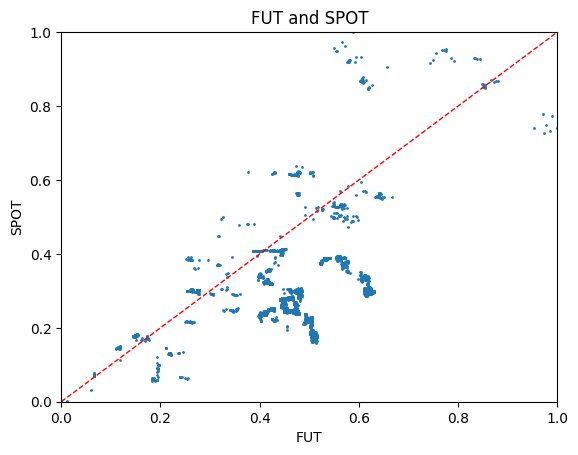

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("FUT and SPOT")
plt.scatter(sample_data.FUT_, sample_data.SPOT_, s=1)
plt.plot([0,1], [0,1], linewidth=1, linestyle="--", c="r")
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel("SPOT")
plt.xlabel("FUT")
plt.show()

In [9]:
import sklearn.metrics as sm
windows=14
for name, df in dfs.items():
  test_y = df.SPOT_[windows:]
  pre_test_y = df.PRED_SPOT[windows:]
  print(f"{name}: [MSE: {sm.mean_squared_error(test_y, pre_test_y): .5f} RMSE: {sm.root_mean_squared_error(test_y, pre_test_y): .5f} R2:{sm.r2_score(test_y, pre_test_y): .5f}]")

linear: [MSE:  0.00104 RMSE:  0.03220 R2: 0.91552]
polynomial: [MSE:  0.08438 RMSE:  0.29048 R2:-5.87620]
gradient_boosting: [MSE:  0.00092 RMSE:  0.03028 R2: 0.92530]
random_forest: [MSE:  0.00097 RMSE:  0.03111 R2: 0.92114]
MNN: [MSE:  0.00110 RMSE:  0.03318 R2: 0.91026]
RNN: [MSE:  0.01532 RMSE:  0.12378 R2:-0.24864]


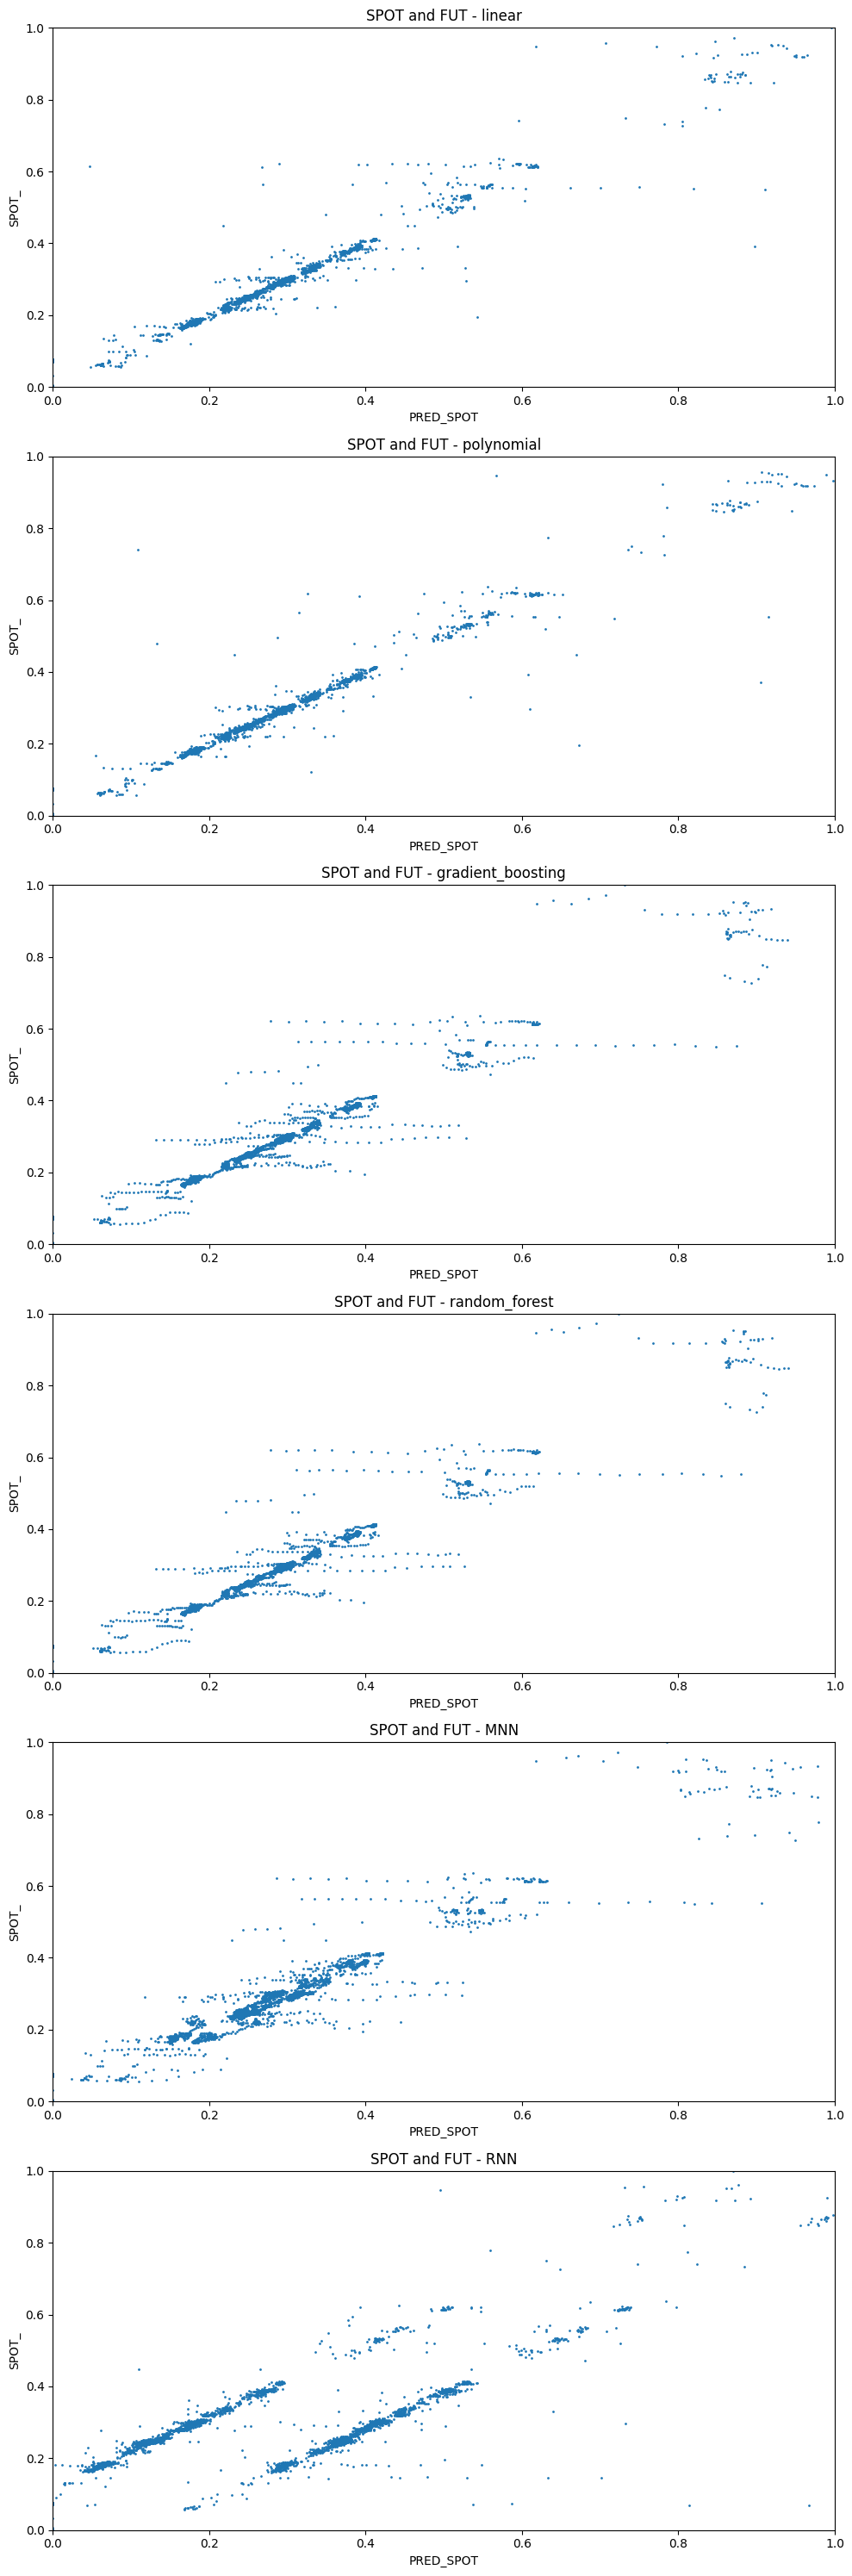

In [ ]:
plt.figure(figsize=(10, 5 * len(dfs)))  # 调整画布大小，适应子图数量
number = len(dfs.keys())

for idx, (key, df) in enumerate(dfs.items()):  # 直接获取键值对
    plt.subplot(number, 1, idx + 1)  # 创建第 idx+1 个子图
    plt.title(f"SPOT and FUT - {key}")
    plt.scatter(df["PRED_SPOT"], df["SPOT_"], s=1)  # 访问 DataFrame 的列
    plt.xlabel("PRED_SPOT")
    plt.ylabel("SPOT_")
    plt.xlim([0, 1])
    plt.ylim([0, 1])

plt.tight_layout()  # 自动调整子图布局，防止重叠
plt.show()